###### Path to notebook: [https://www.github.com/microsoft/presidio/blob/main/docs/samples/python/example_dicom_redactor_evaluation.ipynb](https://www.github.com/microsoft/presidio/blob/main/docs/samples/python/example_dicom_redactor_evaluation.ipynb)

# Evaluate DICOM de-identification performance
This notebook demonstrates how to use the `DicomImagePiiVerifyEngine` to evaluate how well the `DicomImageRedactorEngine` de-identifies text Personal Health Information (PHI) from DICOM images when ground truth labels are available.

## Prerequisites
Before getting started, make sure presidio and the latest version of Tesseract OCR are installed. For detailed documentation, see the [installation docs](https://microsoft.github.io/presidio/installation).

In [ ]:
!pip install presidio_analyzer presidio_anonymizer presidio_image_redactor
!python -m spacy download en_core_web_lg

## Dataset
Sample DICOM files are available for use in this notebook in `./sample_data`. Copies of the original DICOM data were saved into the folder with permission from the dataset owners. Please see the original dataset information below:
> Rutherford, M., Mun, S.K., Levine, B., Bennett, W.C., Smith, K., Farmer, P., Jarosz, J., Wagner, U., Farahani, K., Prior, F. (2021). A DICOM dataset for evaluation of medical image de-identification (Pseudo-PHI-DICOM-Data) [Data set]. The Cancer Imaging Archive. DOI: https://doi.org/10.7937/s17z-r072

In [1]:
import os
import json
import pandas as pd
import pydicom

from presidio_image_redactor import DicomImagePiiVerifyEngine

## Load ground truth
Load the ground truth labels. For more information on the ground truth format, please see the [evaluating DICOM de-identification page](../../image-redactor/evaluating_dicom_redaction.md).

In [2]:
# Set paths
data_dir = "sample_data"
gt_path = "sample_data/ground_truth.json"

In [3]:
# Load ground truth JSON
with open(gt_path) as json_file:
    gt = json.load(json_file)

# Get list of files
gt_dicom_files = list(gt.keys())
gt_dicom_files

['sample_data/0_ORIGINAL.dcm',
 'sample_data/1_ORIGINAL.dcm',
 'sample_data/2_ORIGINAL.dcm',
 'sample_data/3_ORIGINAL.dcm']

## Initialize the verification engine
This engine will be used for both verification and evaluation.

In [4]:
dicom_engine = DicomImagePiiVerifyEngine()

## Verify detected PHI for one DICOM image
To visually identify what text is being detected as PHI on a DICOM image, use the `.verify_dicom_instance()` method.

In [5]:
# Select one file to work with
file_of_interest = gt_dicom_files[0]
gt_file_of_interest = gt[file_of_interest]

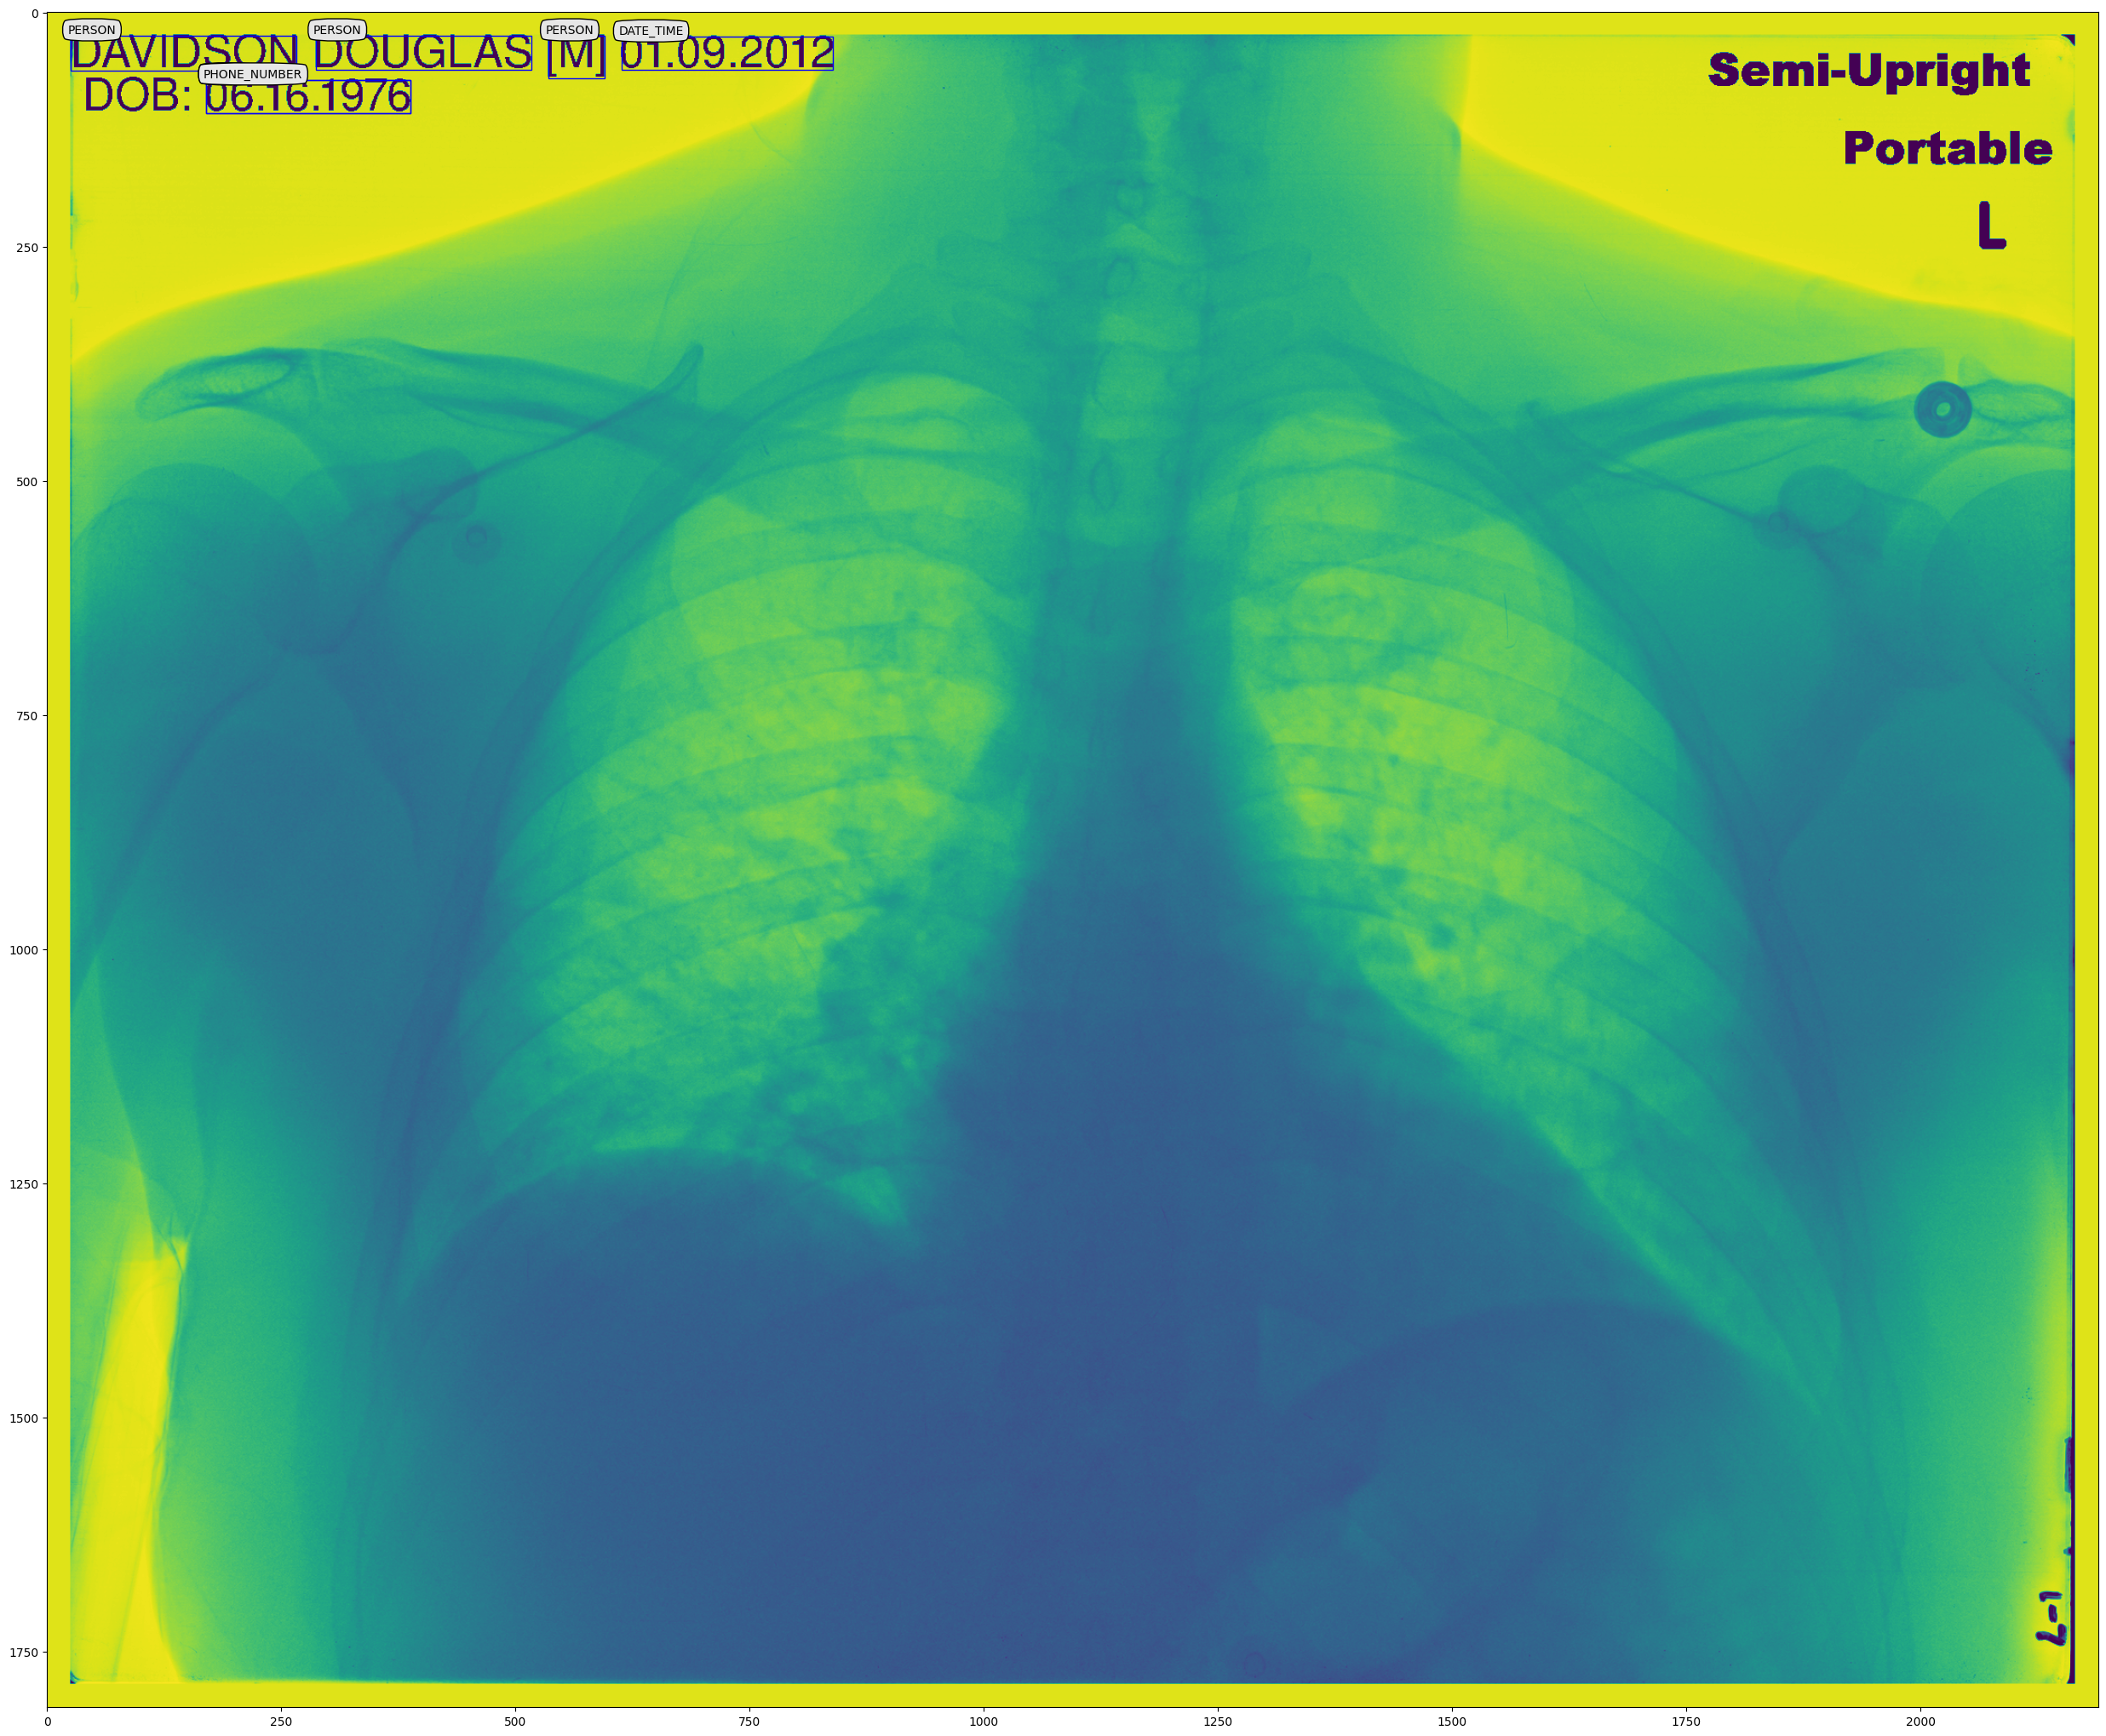

In [6]:
# Return image to visually inspect
instance = pydicom.dcmread(file_of_interest)
verify_image, ocr_results, analyzer_results = dicom_engine.verify_dicom_instance(instance)

## Evaluate de-identification performance
To evaluate how well the actual sensitive text (specified in the ground truth) are identified and redacted, use the `.evaluate_dicom_instance()` method.

In [7]:
def get_PHI_list(PHI: list) -> list:
    """Get list of PHI from ground truth for a single file.
    
    Args:
        PHI_dict (list): List of ground truth or detected text PHI.
    
    Return:
        PHI_list (list): List of PHI (just text).
    """
    PHI_list = []
    for item in PHI:
        PHI_list.append(item['label'])
    
    return PHI_list

### For one image
Display the DICOM image with bounding boxes identifying the detected PHI.

In [ ]:
_, eval_results = dicom_engine.eval_dicom_instance(instance, gt_file_of_interest)

Results

In [9]:
print(f"Precision: {eval_results['precision']}")
print(f"Recall: {eval_results['recall']}")
print(f"All Positives: {get_PHI_list(eval_results['all_positives'])}")
print(f"Ground Truth: {get_PHI_list(eval_results['ground_truth'])}")

Precision: 1.0
Recall: 1.0
All Positives: ['DAVIDSON', 'DOUGLAS', '[M]', '01.09.2012', '06.16.1976']
Ground Truth: ['DAVIDSON', 'DOUGLAS', '[M]', '01.09.2012', '06.16.1976']


### For multiple images

In [10]:
# Initialize lists to turn into results table
list_of_files = gt_dicom_files
list_of_gt = []
list_of_pos = []
list_of_recall = []
list_of_precision = []

Loop through all the files

In [ ]:
for file in gt_dicom_files:
    # Setup
    ground_truth = gt[file]
    instance = pydicom.dcmread(file)
    
    # Evaluate
    _, eval_results = dicom_engine.eval_dicom_instance(instance, ground_truth)
    
    # Save results
    list_of_gt.append(get_PHI_list(eval_results["ground_truth"]))
    list_of_pos.append(get_PHI_list(eval_results["all_positives"]))
    list_of_recall.append(eval_results["recall"])
    list_of_precision.append(eval_results["precision"])

Create a summary results table

In [12]:
# Organize results into a table
all_results_dict = {
    "file": list_of_files,
    "ground_truth": list_of_gt,
    "all_positives": list_of_pos,
    "recall": list_of_recall,
    "precision": list_of_precision
}

df_results = pd.DataFrame(all_results_dict)
df_results

file  \
0  sample_data/0_ORIGINAL.dcm   
1  sample_data/1_ORIGINAL.dcm   
2  sample_data/2_ORIGINAL.dcm   
3  sample_data/3_ORIGINAL.dcm   

                                       ground_truth  \
0  [DAVIDSON, DOUGLAS, [M], 01.09.2012, 06.16.1976]   
1                   [MARTIN, CHAD, [U], 01.01.2000]   
2     [KAUFMAN, SCOTT, [M], 03.09.2012, 07.22.1943]   
3   [MEYER, STEPHANIE, [F], 02.25.2012, 07.16.1953]   

                                      all_positives  recall  precision  
0  [DAVIDSON, DOUGLAS, [M], 01.09.2012, 06.16.1976]     1.0        1.0  
1                   [MARTIN, CHAD, [U], 01.01.2000]     1.0        1.0  
2     [KAUFMAN, 07.22.1943, SCOTT, [M], 03.09.2012]     1.0        1.0  
3   [MEYER, STEPHANIE, [F], 02.25.2012, 07.16.1953]     1.0        1.0

## Experiment with settings
You can experiment with different settings such as `padding_width`, `tolerance`, and any additional arguments to feed into the image analyzer in your DICOM verification engine and see the effect on performance.

> *Changing tolerance does not affect the de-identification logic nor image redaction. Tolerance is only used for matching analyzer results to ground truth labels.*

For example, if we set `padding_width=1`, this can negatively impact the OCR step which identifies all text regardless of PHI status in an image if text is bordering the edges of the image. When the OCR fails to return all text, we cannot reliably detect PHI.

In [ ]:
# Select file
file_of_interest = gt_dicom_files[3]
gt_file_of_interest = gt[file_of_interest]
instance = pydicom.dcmread(file_of_interest)

# Run evaluation with minimal padding (0 padding not allowed)
_, eval_results = dicom_engine.eval_dicom_instance(instance, gt_file_of_interest, padding_width=1)

Notice how low the recall is and how different the detected PHI list is here than in the summary table above which ran de-identification and evaluation with the default  `padding_width=25`.

In [14]:
print(f"Precision: {eval_results['precision']}")
print(f"Recall: {eval_results['recall']}")
print(f"All Positives: {get_PHI_list(eval_results['all_positives'])}")
print(f"Ground Truth: {get_PHI_list(eval_results['ground_truth'])}")

Precision: 1.0
Recall: 0.2
All Positives: ['07.16.1953']
Ground Truth: ['MEYER', 'STEPHANIE', '[F]', '02.25.2012', '07.16.1953']


## Conclusion
The `DicomImagePiiVerifyEngine` allows us to easily do a visual inspection on the identified PHI and also evaluate how well the de-identification worked compared to a provided ground truth.

In the case of these sample images, the precision and recall of the Presidio `DicomImageRedactorEngine` redact function is 1.0 when we use the default values `padding_width=25` and `tolerance=50`.